## Importing all libraries and dataset required in this notebook

In [ ]:
# pip install -U memory_profiler

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

%reload_ext memory_profiler
from memory_profiler import profile
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
np.random.seed=42

In [ ]:
kos_data = pd.read_table("https://raw.githubusercontent.com/rishikatibrewal/Datasets/main/docword.kos.txt",header=None,skiprows=3, delimiter = " ", names =["DocID","WordID","Count"])
nips_data = pd.read_table("https://raw.githubusercontent.com/rishikatibrewal/Datasets/main/docword.nips.txt",header=None,skiprows=3, delimiter = " ", names =["DocID","WordID","Count"])
enron_data = pd.read_table("docword.enron.txt",header=None,skiprows=3, delimiter = " ", names =["DocID","WordID","Count"])

## Functions to perform K-Means using Jaccard distance and create plots

In [ ]:
def J_kmeans(data,jdis,n_clusters=5,max_iter=100,random_state = 42,inertia = False):

  centre_cluster={} # Labels are the keys and the centroid documents are the values
  cluster={} # Labels are the keys and documents in that cluster are the values
  random.seed(random_state)
  
  # picking k centroids randomly from the list of all the documents
  initial_centroids = random.sample(range(data.shape[1]),n_clusters) 
  
  # Assigning the centres of the clusters with these randomly chosen centroids
  for i in range(n_clusters):
      centre_cluster[i]=initial_centroids[i] 

  for iter in range(max_iter):
    # Finding the Jaccard distance from each centroid using jaccard distance matrix
    #Initializing the cluster as empty
    for i in range(n_clusters):
      cluster[i] = [] 
    jac_dis_centroid = pd.DataFrame(jdis).loc[centre_cluster.values(),:]
    # Taking only the rows of jaccard matrix corresponding to the centroid as rows correspond to a document vector

    # Finding the distance of each point from these centroid and assigning to a cluster
    for doc in data:
        dist = list(jac_dis_centroid[doc-1]) #Taking the jaccard distance of each document with respect to the centre_cluster
        x = dist.index(min(dist)) #Finding the minimum of the Jaccard distances from each centroid
        cluster[x].append(doc-1) #Add the document to the cluster of the centroid corresponding to minimum distance
    
    # Recalculating the centroid 
    centroid_update = list()
    for i in range(n_clusters):
        col_sums = list(pd.DataFrame(jdis).loc[cluster[i],cluster[i]].sum(axis=0)) # Finding the sum of Jaccard distances for each document in a cluster wrt to each other
        new_centre = cluster[i][col_sums.index(min(col_sums))] # Finding the lowest sum
        centroid_update.append(new_centre) # Updating the centroid as one with the lowest sum

    for i in range(n_clusters):
        if iter!=max_iter-1: # last step
            centre_cluster[i] = centroid_update[i] # Updating the new centroid in the centroid dictionary
            
  if inertia==True:
    iner_sum = 0
    for i in range(n_clusters):
      centre_index = centre_cluster[i]
      cluster_index = cluster[i]
      iner_sum += sum(jdis[cluster_index,centre_index]**2)
    iner = iner_sum/n_clusters
  result={}
  result[0] = cluster
  result[1] = centre_cluster
  if inertia==True:
    result[2] = iner
  return(result)

In [ ]:
def elbow(data,jdis,k,max_iter=10):

    # Finding the optimum number of clusters for k-means classification
    wcss = []
    for i in range(1,k):
        wcss.append(J_kmeans(data,jdis,n_clusters=i,max_iter=10,inertia=True)[2])
        
    # Plotting the results onto a line graph, 
    # `allowing us to observe 'The elbow'
    plt.figure(figsize=(12,6))
    plt.plot(range(1, 11), wcss,marker='o')
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') # Within cluster sum of squares
    plt.show()

In [ ]:
def kmeans_plot(data,sparse,n_cluster=3,n_components = 3):
  finaldf = []
  y = []
  for i in range(n_cluster): 
    for j in data[i]:
      finaldf.append(sparse[:,j-1])
      y.append(i)
  
  result = pd.DataFrame(y, columns = ["Cluster"])

  pca = KernelPCA(n_components)
  
  principalDF = pd.DataFrame(pca.fit_transform(finaldf), columns = ["Component1","Component2","Component3"])

  finalDF = pd.concat([principalDF, result], axis = 1)
  create_3d_scatter(finalDF)

In [ ]:
def create_3d_scatter(df):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_title('3 component PCA', fontsize = 20)

  ax.scatter(df['Component1'], df['Component2'], df['Component3'], c=df['Cluster'])
  plt.show()

## KOS

In [ ]:
print(kos_data)

        DocID  WordID  Count
0           1      61      2
1           1      76      1
2           1      89      1
3           1     211      1
4           1     296      1
...       ...     ...    ...
353155   3430    6328      1
353156   3430    6644      1
353157   3430    6741      1
353158   3430    6799      1
353159   3430    6822      1

[353160 rows x 3 columns]


In [ ]:
kos_doc_count = kos_data["DocID"].nunique()
kos_word_count = kos_data["WordID"].nunique()
kos_doc_count, kos_word_count

(3430, 6906)

Count of unique documents and words in KOS

In [ ]:
kos_matrix = np.zeros((kos_word_count,kos_doc_count), dtype=np.int64)

In [ ]:
for i in range(int(kos_data.shape[0])):
  word_pos = int(kos_data.WordID[i])
  doc_pos = int(kos_data.DocID[i])
  kos_matrix[word_pos-1][doc_pos-1] = int(kos_data.Count[i])

Creating a matrix of bag of words with each column representing a document vector

In [ ]:
sparse_kos_matrix = np.where(kos_matrix>0,1,0)
kos_mat_df = pd.DataFrame(sparse_kos_matrix,index=pd.RangeIndex(start=1,stop=kos_word_count+1),columns=range(1,kos_doc_count+1))

Creating a matrix of set of words

In [ ]:
%%time
kos_jac_dis_mat = pairwise_distances(np.transpose(kos_matrix), metric='jaccard')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


CPU times: user 59 s, sys: 106 ms, total: 59.1 s
Wall time: 1min


Matrix of Jaccard Distance

In [ ]:
kos_jac_mat = np.round(1-kos_jac_dis_mat,4)

Matrix of Jaccard Index

### Alternative Method to calculate Jaccard Index

In [ ]:
# def jaccard(x,y):
#     z=set(x).intersection(set(y))
#     a=float(len(z))/(len(x)+len(y)-len(z))
#     return a

In [ ]:
# doc_dict = {}
# for i in range(int(kos_data.shape[0])):
#   doc_index = kos_data.DocID[i]
#   if doc_index in doc_dict.keys():
#     doc_dict[doc_index].append(kos_data.WordID[i])
#   else:
#     doc_dict[doc_index] = [kos_data.WordID[i]]

In [ ]:
# jacma = np.zeros((kos_doc_count,kos_doc_count), dtype=np.float64)
# for i in range(1,kos_doc_count+1):
#   for j in range(i,kos_doc_count+1):
#     jacma[i-1][j-1] = jacma[j-1][i-1] = np.round(jaccard(doc_dict[i],doc_dict[j]),4)

### Optimising the value of k for KOS

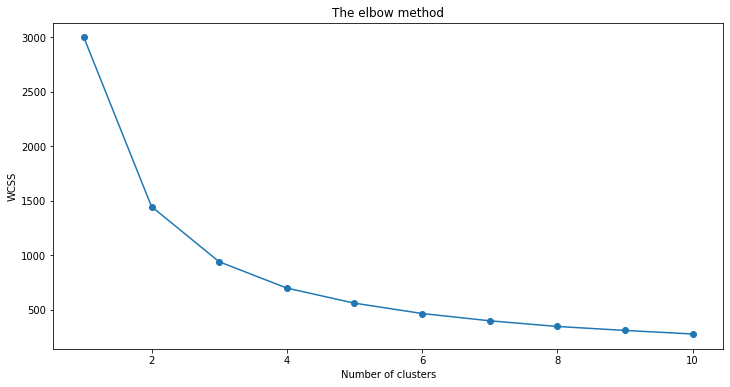

In [ ]:
elbow(kos_mat_df,kos_jac_dis_mat,11,200)

In [ ]:
%%time
%%memit
kos_Kmeans = J_kmeans(kos_mat_df,kos_jac_dis_mat,n_clusters=3,max_iter=100)

peak memory: 1177.57 MiB, increment: 1.49 MiB
CPU times: user 29.5 s, sys: 521 ms, total: 30.1 s
Wall time: 30.2 s


Applying K-Means using Jaccard distance as a distance metric and k=3

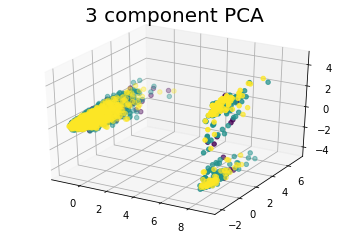

In [ ]:
kmeans_plot(kos_Kmeans[0],sparse_kos_matrix ,n_cluster=3)

Using PCA to visualize the clusters

## NIPS

In [ ]:
print(nips_data)

        DocID  WordID  Count
0           1       2      1
1           1      39      1
2           1      42      3
3           1      77      1
4           1      95      1
...       ...     ...    ...
746311   1500   12382      1
746312   1500   12388      3
746313   1500   12390      1
746314   1500   12393      1
746315   1500   12414      1

[746316 rows x 3 columns]


In [ ]:
nips_doc_count = nips_data["DocID"].nunique()
nips_word_count = max(nips_data["WordID"])
nips_doc_count, nips_word_count

(1500, 12419)

Count of unique documents and words in NIPS

In [ ]:
nips_matrix = np.zeros((nips_word_count,nips_doc_count), dtype=np.int64)

In [ ]:
for i in range(nips_data.shape[0]):
  word_pos = int(nips_data.WordID[i])
  doc_pos = int(nips_data.DocID[i])
  nips_matrix[word_pos-1][doc_pos-1] = int(nips_data.Count[i])

Creating a matrix of bag of words with each column representing a document vector

In [ ]:
sparse_nips_matrix = np.where(nips_matrix>0,1,0)
nips_mat_df = pd.DataFrame(sparse_nips_matrix,index=pd.RangeIndex(start=1,stop=nips_word_count+1),columns=range(1,nips_doc_count+1))

Creating a matrix of set of words

In [ ]:
%%time
nips_jac_dis_mat = pairwise_distances(np.transpose(nips_matrix), metric='jaccard')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


CPU times: user 20.2 s, sys: 12.7 ms, total: 20.2 s
Wall time: 20.1 s


Matrix of Jaccard Distance

In [ ]:
nips_jac_mat = np.round(1-nips_jac_dis_mat,4)

Matrix of Jaccard Index

### Alternative Method to calculate Jaccard Index

In [ ]:
# def jaccard(x,y):
#     z=set(x).intersection(set(y))
#     a=float(len(z))/(len(x)+len(y)-len(z))
#     return a

In [ ]:
# doc_dict = {}
# for i in range(int(nips_data.shape[0])):
#   doc_index = nips_data.DocID[i]
#   if doc_index in doc_dict.keys():
#     doc_dict[doc_index].append(nips_data.WordID[i])
#   else:
#     doc_dict[doc_index] = [nips_data.WordID[i]]

In [ ]:
# jacma = np.zeros((nips_doc_count,nips_doc_count), dtype=np.float64)
# for i in range(1,nips_doc_count+1):
#   for j in range(i,nips_doc_count+1):
#     jacma[i-1][j-1] = jacma[j-1][i-1] = np.round(jaccard(doc_dict[i],doc_dict[j]),4)

### Optimising the value of k for NIPS

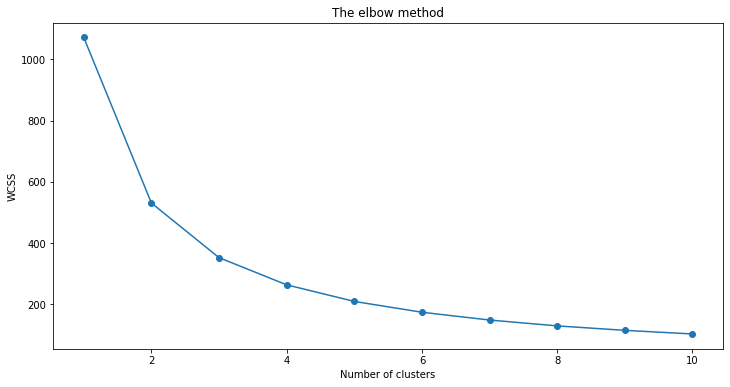

In [ ]:
elbow(nips_mat_df,nips_jac_dis_mat,11,200)

In [ ]:
%%time
%%memit
nips_Kmeans = J_kmeans(nips_mat_df,nips_jac_dis_mat,3,100)

peak memory: 1549.71 MiB, increment: 0.07 MiB
CPU times: user 11 s, sys: 204 ms, total: 11.2 s
Wall time: 11.3 s


Applying K-Means using Jaccard distance as a distance metric and k=3.

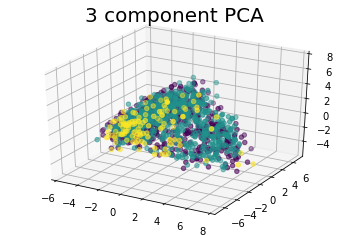

In [ ]:
kmeans_plot(nips_Kmeans[0],sparse_nips_matrix ,n_cluster=3)

Using PCA to visualize the clusters

#ENRON

In [ ]:
print(enron_data)

         DocID  WordID  Count
0            1     118      1
1            1     285      1
2            1    1229      1
3            1    1688      1
4            1    2068      1
...        ...     ...    ...
3710415  39861   18448      1
3710416  39861   18848      1
3710417  39861   23449      1
3710418  39861   25721      1
3710419  39861   27196      1

[3710420 rows x 3 columns]


In [ ]:
df2 = enron_data['DocID'].value_counts().to_frame().reset_index()
df2.columns = ["DocID","Freq"]
df3 = df2[df2["Freq"]>200] #docs with more than 200 distinct words ignoring the multiplicity of a word
df3

,DocID,Freq
0,30671,2120
1,33962,2120
2,31445,2075
3,28980,2050
4,33931,2050
...,...,...
3648,26667,201
3649,27598,201
3650,12894,201
3651,9272,201


In [ ]:
doclist=df3["DocID"].to_numpy()

In [ ]:
doc_dict = {}
for i in range(int(enron_data.shape[0])):
  doc_index = enron_data.DocID[i]
  if doc_index in doclist:
    if doc_index in doc_dict.keys():
      doc_dict[doc_index].append(enron_data.WordID[i])
    else:
      doc_dict[doc_index] = [enron_data.WordID[i]]

In [ ]:
enron_doc_count = len(doclist)
enron_word_count = max(enron_data["WordID"])

In [ ]:
enron_doc_count, enron_word_count

(3653, 28102)

In [ ]:
enron_matrix = np.zeros((enron_word_count,enron_doc_count), dtype=np.int64)

In [ ]:
doc_pointer = 0
for doc_index in doc_dict:
  for word_index in doc_dict[doc_index]:
    enron_matrix[word_index-1][doc_pointer] = 1
  doc_pointer+=1

In [ ]:
enron_mat_df = pd.DataFrame(enron_matrix,index=pd.RangeIndex(start=1,stop=enron_word_count+1),columns=range(1,enron_doc_count+1))

In [ ]:
%%time
enron_jac_dis_mat = pairwise_distances(np.transpose(enron_matrix), metric='jaccard')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


CPU times: user 4min 43s, sys: 290 ms, total: 4min 43s
Wall time: 4min 50s


In [ ]:
enron_jac_mat = np.round(1-enron_jac_dis_mat,4)

### Optimising the value of k for ENRON

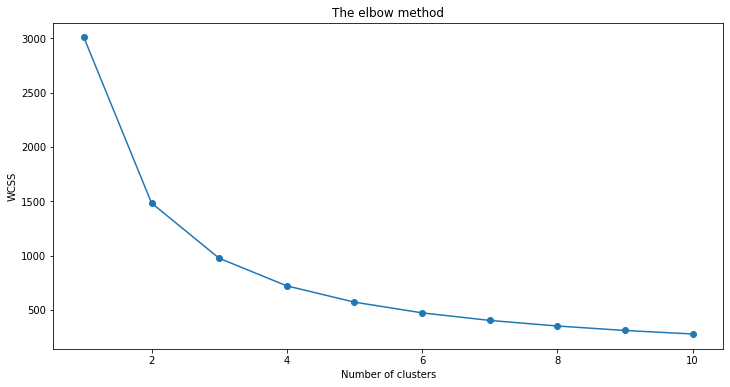

In [ ]:
elbow(enron_mat_df,enron_jac_dis_mat,11,200)

In [ ]:
%%time
%%memit
enron_Kmeans = J_kmeans(enron_mat_df,enron_jac_dis_mat,3,100)

peak memory: 2823.36 MiB, increment: 2.25 MiB
CPU times: user 37.3 s, sys: 459 ms, total: 37.7 s
Wall time: 40.7 s


Applying K-Means using Jaccard distance as a distance metric and k=3

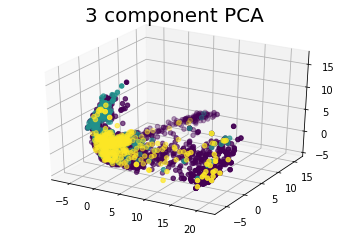

In [ ]:
kmeans_plot(enron_Kmeans[0],enron_matrix ,n_cluster=3)

Using PCA to visualize the clusters